## Steps followed 
1. Exploratory Data Analysis
2. Data Cleaning and Prepration
3. Model building, evaluation, parameter tuning
4. Make predictions

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.experimental import enable_halving_search_cv 

from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_fscore_support, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, HalvingGridSearchCV

from imblearn.ensemble import BalancedRandomForestClassifier, BalancedBaggingClassifier, RUSBoostClassifier

## Read Data

In [56]:
df = pd.read_excel('DS_Assignment.xlsx')
print(df.shape)
df.sample(10)

(45000, 112)


userID  Contact_ind  Customer_status  ActiveSinceDays  num_AcD_m0  \
27286   32287            1                3             1747           6   
13270   18271            1                4             1018           4   
8405    13406            1                0             1696           2   
9937    14938            1                3              740           1   
22034   27035            0                2              449           1   
5261    10262            1                4              191           2   
3504     8505            1                3             1673           2   
43818   48819            1                2              233           7   
29988   34989            1                4             1423           5   
30999   36000            1                4              378           5   

       num_AcD_m1  r_AcD_m0_m12  r_AcD_m0_m123  daystofirstload  \
27286           5     80.000000      75.000000              360   
13270           6     57.142857      75.000000                1   
8405            5     66.666667      66.666667             1134   
9937            0    200.000000     150.000000                0   
22034           2     20.000000      30.000000                0   
5261            8     44.444444      46.153846                1   
3504            0     57.142857      66.666667              714   
43818          11     77.777778     116.666667              130   
29988           6     90.909091     107.142857               70   
30999           4    111.111111      93.750000                0   

       dayssincelastload  ...  InAllRev_m1  InAllRev_m2  r_InAllRev_m0_m1  \
27286                  8  ...       670.00       879.00       1298.062593   
13270                 62  ...      2200.00      1432.00         13.630168   
8405                 157  ...         0.00         0.00          0.000000   
9937                 182  ...         0.00         0.00          0.000000   
22034                  3  ...     30000.00    105001.65         89.997000   
5261                  71  ...      1705.49         0.00        148.257534   
3504                  67  ...         0.00         6.00      28100.000000   
43818                 43  ...      1040.00       110.00         14.409222   
29988                 42  ...      1600.00       500.00         31.230481   
30999                 15  ...         0.00      3093.69          0.000000   

       r_InAllRev_m0_m2  tot_InAllRev_3m  OgAllRev_m0  OgAllRev_m1  \
27286        989.772727         10259.00      8290.64      1095.78   
13270         20.935101          3932.00       508.00      1935.00   
8405           0.000000             0.00      1829.00       399.00   
9937           0.000000             0.00       399.00         0.00   
22034         25.713637        162001.65     27050.00     94840.00   
5261      253000.000000          4235.49      2540.00      1883.00   
3504        4014.285714           287.00       452.00         0.00   
43818        135.135135          1300.00       148.00      1139.00   
29988         99.800399          2600.00       521.00      1558.00   
30999          0.000000          3093.69      2863.00       553.00   

       OgAllRev_m2  tot_OgAllRev_3m  targetid  
27286      1093.80         10480.22         0  
13270      1727.00          4170.00         0  
8405          0.00          2228.00         1  
9937          0.00           399.00         0  
22034    105040.00        226930.00         0  
5261          0.00          4423.00         1  
3504        142.00           594.00         1  
43818        10.00          1297.00         0  
29988       920.00          2999.00         0  
30999     11890.88         15306.88         0  

[10 rows x 112 columns]

## EDA

In [3]:
# check if any column is interepreted as object, it looks like everything is numerical
try :
    object_cols = df.describe(include=object)
except Exception as e :
    print("No object types detected")

No object types detected


### check class imbalance

In [4]:
# There is class imblanace with 75 - 25 % ratio between churn and not churn
df.targetid.value_counts()

0    35833
1     9167
Name: targetid, dtype: int64

### Do some basic sanity checks

#### Check null values
- six columns have null values
- Some cells with values -999 or negative number might be missing values
- drop columns with single value

In [5]:
df.isna().sum().sort_values(ascending=False)[:10]

r_avg_max_rechX_m2    12672
r_avg_max_rtlX_m2     11418
r_avg_max_rtlX_m1     11162
r_avg_max_rechX_m1    10519
r_avg_max_rtlX_m0      9805
r_avg_max_rechX_m0     6199
tot_billX_amt_m012        0
billX_amt_m2              0
billX_amt_m1              0
billX_amt_m0              0
dtype: int64

#### check for duplicate values 

In [6]:
duplicate = df[df.duplicated()]
duplicate

Empty DataFrame
Columns: [userID, Contact_ind, Customer_status, ActiveSinceDays, num_AcD_m0, num_AcD_m1, r_AcD_m0_m12, r_AcD_m0_m123, daystofirstload, dayssincelastload, tot_RevUo_m0, tot_RevUo_m1, tot_RevUo_m2, r_tot_RevUo_m0_m1, r_tot_RevUo_m1_m2, r_tot_RevUo_m0_m12, avg_RevUo_m0, avg_RevUo_m1, avg_RevUo_m2, chg_RevUo_l0_1m, chg_RevUo_l1_2m, chg_RevUo_l2_3m, tot_LdCnt_m0, tot_LdCnt_m1, tot_LdCnt_m2, max_RevUo_m0, max_RevUo_m1, max_RevUo_m2, r_avg_RevUo_m0_m1, r_avg_RevUo_m1_m2, avgdays_btw_loads_l6, tot_failed_LdTxnCnt_3m, r_failed_LdTxnCnt_m0_m12, tot_rtlX_m0, tot_rtlX_m1, tot_rtlX_m2, r_tot_rtlX_m0_m1, r_tot_rtlX_m1_m2, r_tot_rtlX_m0_m12, avg_rtlX_m0, avg_rtlX_m1, avg_rtlX_m2, max_rtlX_m0, max_rtlX_m1, max_rtlX_m2, r_avg_max_rtlX_m0, r_avg_max_rtlX_m1, r_avg_max_rtlX_m2, RtlTxns_cnt_m0, RtlTxns_cnt_m1, RtlTxns_cnt_m2, r_RtlTxns_cnt_m0_m1, r_RtlTxns_cnt_m1_m2, sum_r_RtlTxns_cnt, fail_RtlTxncnt_m0, RtlTxn_dayscnt_m0, RtlTxn_dayscnt_m1, RtlTxn_dayscnt_m2, tot_rechX_m0, tot_rechX_m1, tot_rechX_m2, chg_rechX_l0_1m, chg_rechX_l1_2m, avg_rechX_m0, avg_rechX_m1, avg_rechX_m2, max_rechX_m0, max_rechX_m1, max_rechX_m2, r_avg_max_rechX_m0, r_avg_max_rechX_m1, r_avg_max_rechX_m2, rechtxns_cnt_m0, rechtxns_cnt_m1, rechtxns_cnt_m2, rechtxn_dayscnt_m0, rechtxn_dayscnt_m1, rechtxn_dayscnt_m2, billX_amt_m0, billX_amt_m1, billX_amt_m2, tot_billX_amt_m012, r_billX_amt_m0_m1, r_billX_amt_m0_m12, r_billX_amt_m1_m2, billX_cnt_m0, billX_cnt_m1, billX_cnt_m2, rech_amt_m0, rech_amt_m1, rech_amt_m2, r_rech_amt_m0_m1, r_rech_amt_m1_m2, sum_r_rech_amt_m1m2_m0m1, r_rech_amt_m0_m12, avgbal_m0, avgbal_m1, avgbal_m2, resolved_cnt_m2, tot_resolved_cnt_m012, ...]
Index: []

[0 rows x 112 columns]

In [7]:
#check for duplicate userId rows
duplicate = df['userID'][df['userID'].duplicated()]
duplicate

Series([], Name: userID, dtype: int64)

#### Drop columns with single value, no predicting power

In [8]:
print(list(df.nunique()[df.nunique()==1].index))
df.drop(columns=list(df.nunique()[df.nunique()==1].index), inplace=True)

['avgdays_btw_loads_l6', 'fail_RtlTxncnt_m0']


In [9]:
def plot_heat_map(df) :
    sns.set_theme(style="white")
    # Compute the correlation matrix
    corr = df.corr()
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(10, 6))
    dataplot=sns.heatmap(df.corr())

### Correlation plots

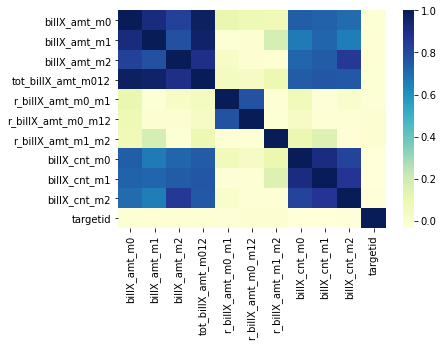

In [58]:
# columns with bill amount, mostly have very little correlation
df_bill_cols = df[df.columns[df.columns.str.contains(pat = 'billX')]]
df_bill_cols.loc[:,'targetid'] = df['targetid'].values
ax = sns.heatmap(df_bill_cols.corr(),  cmap="YlGnBu")

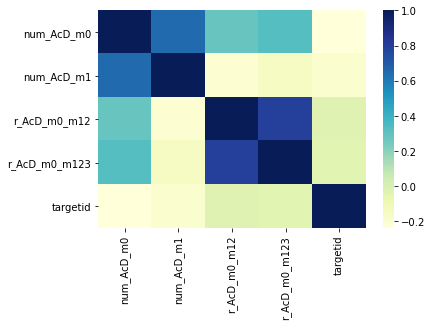

In [11]:
# columns with AcD
df_AcD_cols = df[df.columns[df.columns.str.contains(pat = 'AcD')]]
df_AcD_cols.loc[:,'targetid'] = df['targetid'].values
ax = sns.heatmap(df_AcD_cols.corr(),  cmap="YlGnBu")

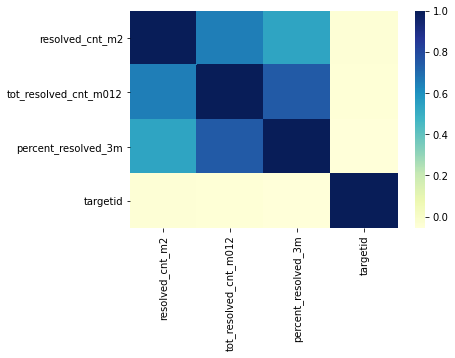

In [12]:
# columns with resolved
df_resolved_cols = df[df.columns[df.columns.str.contains(pat = 'resolved')]]
df_resolved_cols.loc[:,'targetid'] = df['targetid'].values
ax = sns.heatmap(df_resolved_cols.corr(),  cmap="YlGnBu")

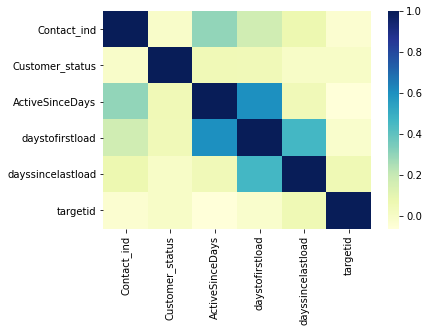

In [13]:
# Check correlation with columns of clear names
cols = ['Contact_ind', 'Customer_status', 'ActiveSinceDays', 'daystofirstload', 'dayssincelastload', 'targetid']
ax = sns.heatmap(df[cols].corr(),  cmap="YlGnBu")

## Data Preparation

#### check for distribution of columns with missing values

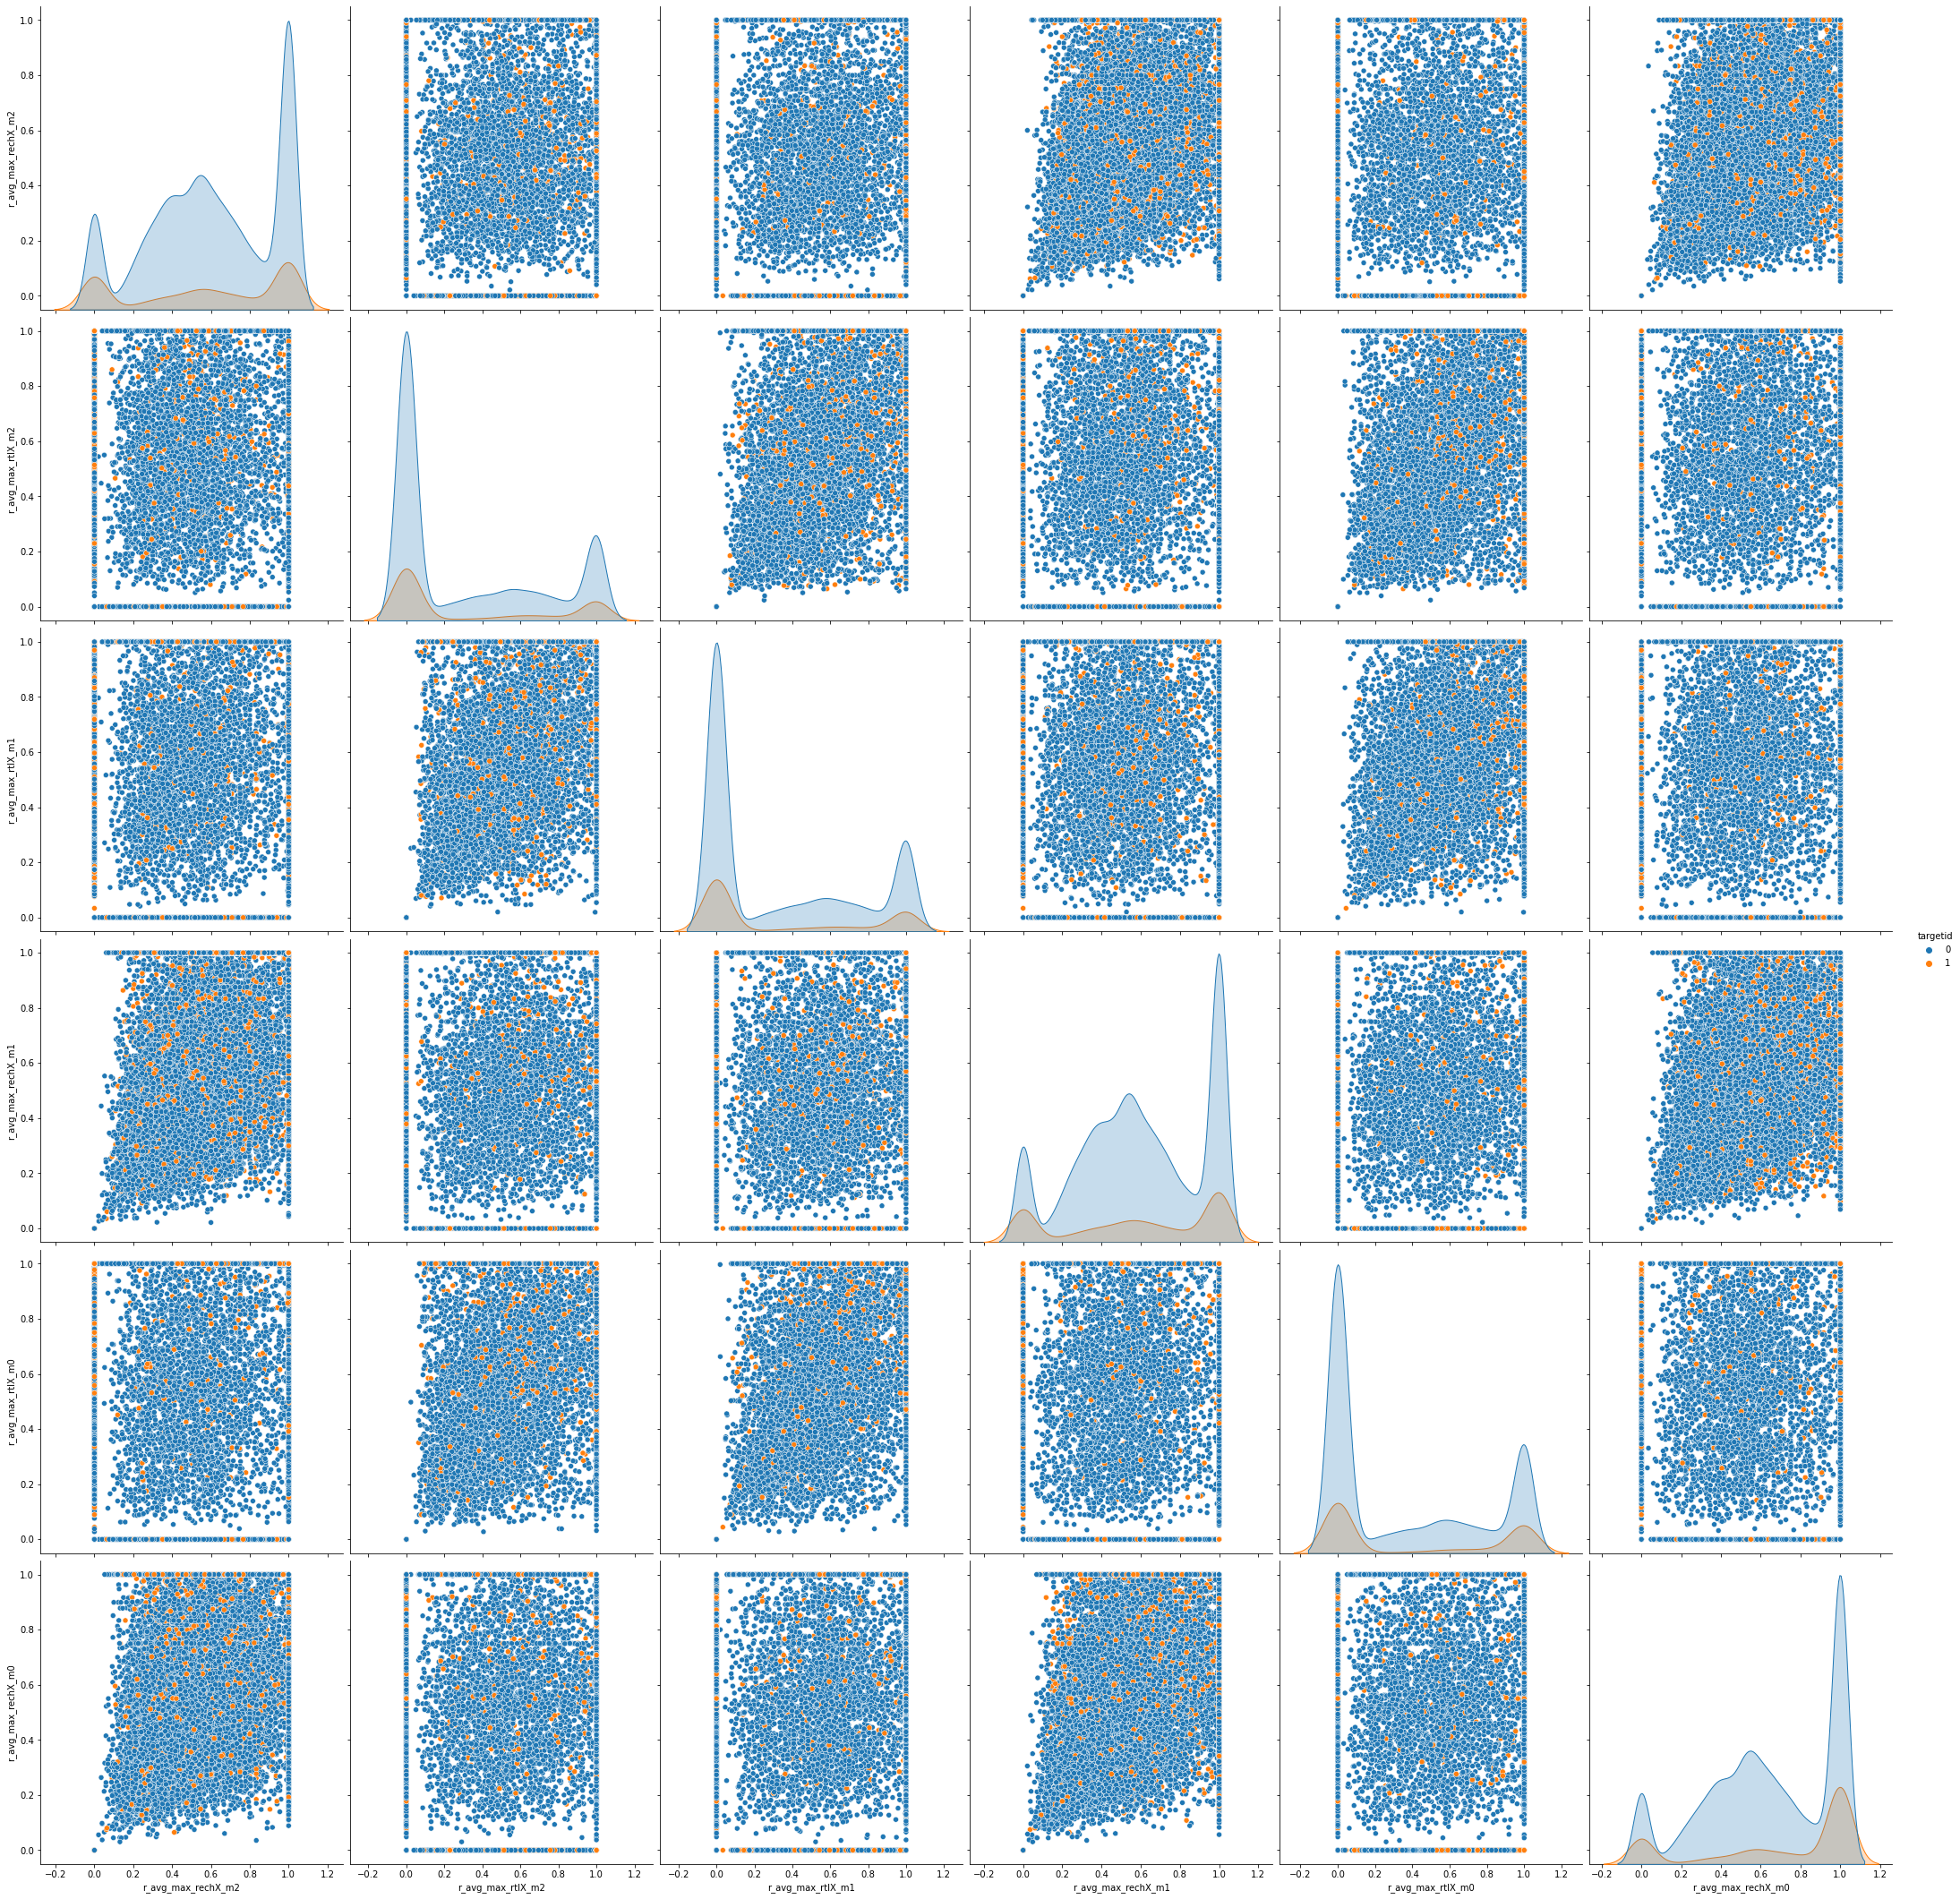

In [14]:
sns.pairplot(df[['r_avg_max_rechX_m2',
           'r_avg_max_rtlX_m2',
           'r_avg_max_rtlX_m1',
           'r_avg_max_rechX_m1',
           'r_avg_max_rtlX_m0',
           'r_avg_max_rechX_m0','targetid']],hue='targetid',height=5)

In [15]:
# Fill missing values with mean

cols = ['r_avg_max_rechX_m2', 
        'r_avg_max_rtlX_m2',
        'r_avg_max_rtlX_m1',
        'r_avg_max_rechX_m1',
        'r_avg_max_rtlX_m0',
        'r_avg_max_rechX_m0'
       ]
df[cols] = df[cols].fillna(df[cols].mean())

In [16]:
# Predictor variables are separated

cols = ['userID',
        'targetid'
       ]
X = df.drop(columns = cols)
y = df.targetid

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(36000, 108) (9000, 108) (36000,) (9000,)


In [18]:
standard_scaler = StandardScaler(with_mean=False)
standard_scaler.fit(X_train)

# scale training set
X_train = standard_scaler.transform(X_train)
# scale test set
X_test = standard_scaler.transform(X_test)

## Modeling

#### Define functions for plots

In [19]:
def plot_confusion_matrix(y_test, y_pred):
    '''
    plot confusion matrix for given actual and predicted values
    '''
    
    # get confusion matrix and display 
    (tn, fp, fn, tp) = confusion_matrix(y_test,y_pred).ravel()
    cm =np.array([[tp, fp],[fn, tn]])

    # display churn vs no churn matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Churn', 'No Churn'])
    disp.plot(xticks_rotation='vertical', colorbar=False, cmap='Greens')
    disp.ax_.set_xlabel("Actual")
    disp.ax_.set_ylabel("Predicted")
    disp.ax_.xaxis.set_label_position('top')
    plt.show()
    

def roc_train_test(fpr_ts, tpr_ts, fpr_tr, tpr_tr):
    '''
    plot ROC for train and test set
    '''
    roc_auc_ts = auc(fpr_ts, tpr_ts)
    roc_auc_tr = auc(fpr_tr, tpr_tr)

    fig = plt.figure(figsize= (14,6))
    plt.grid(visible=True, which='major', color='grey', linestyle='-')
    plt.plot(fpr_ts, tpr_ts, color='green', lw=1, label='Test ROC Curve (area = %0.3f)' % roc_auc_ts)
    plt.plot(fpr_tr, tpr_tr, color='red', lw=1, label='Train Set ROC Curve (area = %0.3f)' % roc_auc_tr)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc="lower right",prop={'size': 22})
    plt.show()

In [20]:
def plot_model_metrics(clf, X_train, y_train, X_test, y_test) :
    y_pred_prob = clf.predict_proba(X_test).T[1]
    fpr_test, tpr_test, threshold = roc_curve(y_test, y_pred_prob)

    pred_prob_train = clf.predict_proba(X_train).T[1]
    fpr_train, tpr_train, threshold_train = roc_curve(y_train, pred_prob_train)

    # plot roc curve
    roc_train_test(fpr_test, tpr_test,fpr_train, tpr_train)

    # plot confusion matrix with threshold set
    opt_threshold = round(threshold[np.argmax(tpr_test-fpr_test)], ndigits = 4)
    y_pred = (clf.predict_proba(X_test)[:,1] >= opt_threshold).astype(int)
    plot_confusion_matrix(y_test, y_pred)

    # Get Precision Recall
    return pd.DataFrame(precision_recall_fscore_support(y_test, y_pred, average='binary')[:3],
                 columns=['Confusion Matrix'],
                 index=['Precision', 'Recall', 'F1 Score']), opt_threshold

### Random Forest Classifier

#### GridSearch cross validation to find optimal hyperparameters

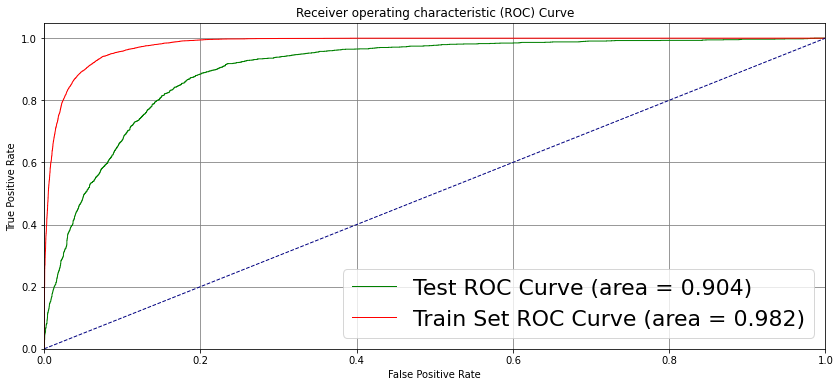

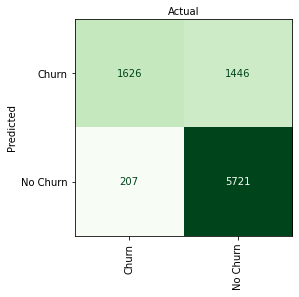

Confusion Matrix
Precision          0.529297
Recall             0.887070
F1 Score           0.662997

In [21]:
param_grid = {'max_depth': [5,8,10,12,14,16],'min_samples_split': [10,20,30]}
base_estimator = RandomForestClassifier(random_state=0)
sh = HalvingGridSearchCV(base_estimator, param_grid, cv=5,scoring='f1',
                         factor=2, resource='n_estimators',
                         max_resources=30).fit(X_train, y_train)
rf_clf = sh.best_estimator_

df_conf, opt_threshold = plot_model_metrics(rf_clf, X_train, y_train, X_test, y_test)
df_conf

### Support Vector Machines

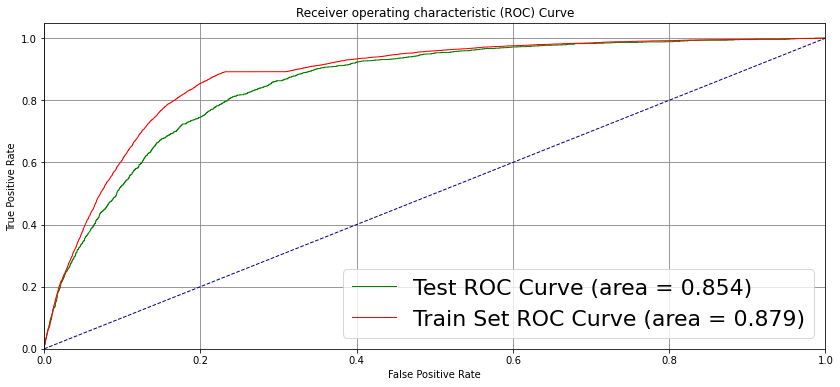

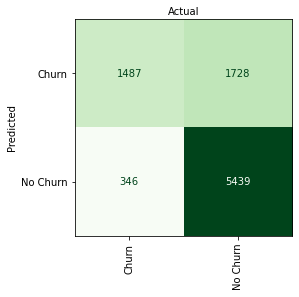

CPU times: user 22min 21s, sys: 13.5 s, total: 22min 35s
Wall time: 41min 41s


Confusion Matrix
Precision          0.462519
Recall             0.811238
F1 Score           0.589144

In [23]:
%%time
svc_clf = SVC(kernel='rbf', probability=True)
svc_clf.fit(X_train, y_train)
df_conf, opt_threshold = plot_model_metrics(svc_clf, X_train, y_train, X_test, y_test)
df_conf

## Handle class imbalance

### Balanced Bagging Classifier

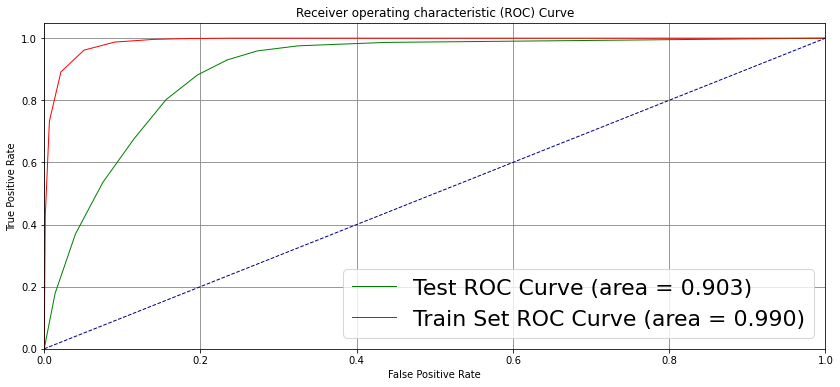

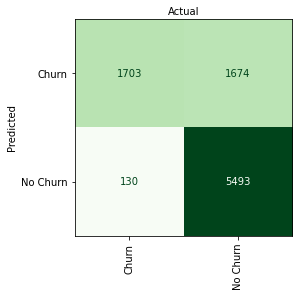

Confusion Matrix
Precision          0.504294
Recall             0.929078
F1 Score           0.653743

In [24]:
bbc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)
bbc.fit(X_train, y_train)
df_conf, opt_threshold = plot_model_metrics(bbc, X_train, y_train, X_test, y_test)
df_conf

### Random Undersample boosting classifier

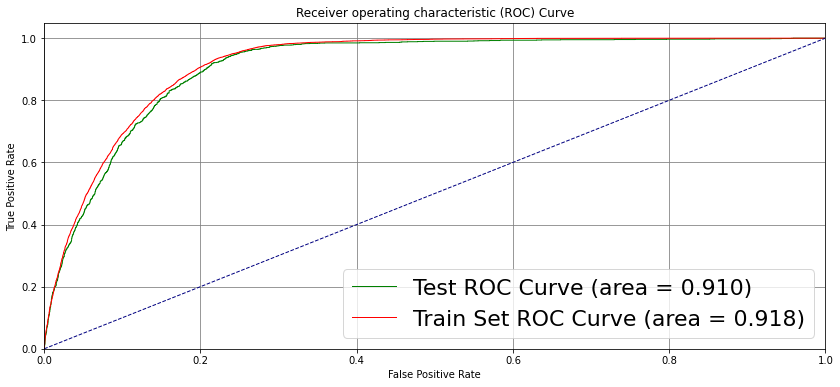

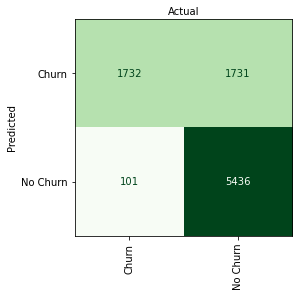

Confusion Matrix
Precision          0.500144
Recall             0.944899
F1 Score           0.654079

In [25]:
from imblearn.ensemble import RUSBoostClassifier

rusboost = RUSBoostClassifier(n_estimators=200, algorithm='SAMME.R',
                              random_state=0)
rusboost.fit(X_train, y_train)
df_conf, opt_threshold = plot_model_metrics(rusboost, X_train, y_train, X_test, y_test)
df_conf

## Validation Set Prediction

In [40]:
df_valid = pd.read_excel('DS_Assignment_Validation_Set (1).xlsx')

# rename empty target columns
df_valid.rename(columns={"Unnamed: 111": "targetid"}, inplace=True)
df_valid.sample(5)

userID  Contact_ind  Customer_status  ActiveSinceDays  num_AcD_m0  \
2188    2189            1                3             1218           3   
4104    4105            0                3              569           3   
2437    2438            1                3              406           2   
2933    2934            0                3              347           7   
2962    2963            1                4              840           2   

      num_AcD_m1  r_AcD_m0_m12  r_AcD_m0_m123  daystofirstload  \
2188           3     75.000000     100.000000               40   
4104           2    200.000000     112.500000                7   
2437           7     30.769231      35.294118               12   
2933           7    127.272727     123.529412                0   
2962           4     80.000000      85.714286                6   

      dayssincelastload  ...  InAllRev_m1  InAllRev_m2  r_InAllRev_m0_m1  \
2188                134  ...          0.0      14408.0          0.000000   
4104                 10  ...       5320.0          0.0        123.097162   
2437                 53  ...       4020.0      42000.0        508.555086   
2933                  8  ...       1100.0        500.0        145.322434   
2962                181  ...          0.0          0.0          0.000000   

      r_InAllRev_m0_m2  tot_InAllRev_3m  OgAllRev_m0  OgAllRev_m1  \
2188          0.000000          14408.0       399.00       399.00   
4104     655000.000000          11870.0      8392.00      3583.00   
2437         48.686936          66469.0     20449.74      6118.64   
2933        319.361277           3200.0      1779.00       966.00   
2962          0.000000              0.0       818.00       370.00   

      OgAllRev_m2  tot_OgAllRev_3m  targetid  
2188      14663.0         15461.00       NaN  
4104          0.0         11975.00       NaN  
2437      41890.0         68458.38       NaN  
2933        511.0          3256.00       NaN  
2962          0.0          1188.00       NaN  

[5 rows x 112 columns]

In [41]:
df_valid_report = df_valid[['userID', 'targetid']]

In [45]:
# Drop columns not used during training
cols = ['avgdays_btw_loads_l6',
        'fail_RtlTxncnt_m0',
        'userID',
        'targetid'
       ]
df_valid = df_valid.drop(columns = cols)

#### Check of null values in validation set

In [47]:
df_valid.isna().sum().sort_values(ascending=False)[:15]

r_avg_max_rechX_m2    1412
r_avg_max_rtlX_m1     1261
r_avg_max_rtlX_m2     1233
r_avg_max_rechX_m1    1209
r_avg_max_rtlX_m0     1083
r_avg_max_rechX_m0     680
tot_OgAllRev_3m          2
billX_amt_m2             2
billX_cnt_m2             2
billX_cnt_m1             2
billX_cnt_m0             2
r_billX_amt_m0_m12       2
r_billX_amt_m0_m1        2
tot_billX_amt_m012       2
rechtxn_dayscnt_m2       2
dtype: int64

#### Fill in missing values in validation set with training data mean

In [59]:
df_valid.fillna(df.mean(), inplace=True)

In [61]:
standard_scaler.fit(df_valid)

StandardScaler(with_mean=False)

### Using random undersampler boosting classifier as it has highest AUC, and train and test area is almost same

In [68]:
y_valid_pred = (rusboost.predict_proba(df_valid)[:,1] >= opt_threshold)
df_valid_report['targetid'] = y_valid_pred.astype(int)
df_valid_report

userID  targetid
0          1         0
1          2         0
2          3         0
3          4         0
4          5         0
...      ...       ...
4995    4996         0
4996    4997         0
4997    4998         0
4998    4999         0
4999    5000         0

[5000 rows x 2 columns]

In [67]:
#persist the final predictions to csv
df_valid_report.to_csv('validation_pred.csv', index=False)